In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import layers, losses, optimizers, metrics
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
import pandas as pd
import random
import gradio as gr
from PIL import Image
import importlib
import utils
from IPython.display import HTML
import base64
from io import BytesIO

importlib.reload(utils)


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

keras.mixed_precision.set_global_policy("mixed_float16")

NUM_OF_CLASSES = 200
BATCH_SIZE = 8
IMG_HEIGHT = 500
IMG_WIDTH = 500
TARGET_HEIGHT = 224
TARGET_WIDTH = 224

MEAN = (
    122.74145,
    127.34256,
    109.01317,
)
STD = (
    59.439457,
    58.26029,
    68.00734,
)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9


Download and setup the CUB-200-2011 bird dataset.

In [3]:
ds_train_full, ds_info = tfds.load(
    "caltech_birds2011",
    split="train",
    shuffle_files=True,
    data_dir="./datasets",
    with_info=True,
)
ds_test_full = tfds.load(
    "caltech_birds2011",
    split="test",
    shuffle_files=True,
    data_dir="./datasets",
    with_info=False,
)

assert isinstance(ds_train_full, tf.data.Dataset)
assert isinstance(ds_test_full, tf.data.Dataset)
assert isinstance(ds_info, DatasetInfo)

ds_train_full_N = ds_info.splits["train"].num_examples


@tf.function
def preprocess(data):
    image = data["image"]
    label = data["label"]
    bbox = data["bbox"]
    image = tf.cast(image, tf.float32) / 255.0
    # image = utils.normalize_img(image, MEAN, STD)
    image = utils.crop_to_bounding_box(image, bbox)
    image = utils.resize_with_pad_img(image, TARGET_HEIGHT, TARGET_WIDTH)
    return image, label


hflip_transform = keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.01, fill_mode="constant", seed=SEED),
        layers.RandomTranslation(
            0.1, 0.1, fill_mode="constant", seed=SEED, dtype=tf.float32
        ),
    ]
)
v_flip_transform = keras.Sequential(
    [
        layers.RandomFlip("vertical", seed=SEED - 1),
        layers.RandomRotation(0.01, fill_mode="constant", seed=SEED - 1),
        layers.RandomTranslation(
            0.1, 0.1, fill_mode="constant", seed=SEED - 1, dtype=tf.float32
        ),
    ]
)
shake_transform = keras.Sequential(
    [
        layers.RandomZoom(0.3, fill_mode="constant", seed=SEED),
        layers.RandomRotation(0.1, fill_mode="constant", seed=SEED + 1),
        layers.RandomTranslation(
            0.3, 0.3, fill_mode="constant", seed=SEED + 1, dtype=tf.float32
        ),
    ]
)
brightness_transform = layers.RandomBrightness(
    [-0.3, 0.3], value_range=(0.0, 1.0), seed=SEED, dtype=tf.float32
)
contrast_transform = layers.RandomContrast((0.5, 0.9), seed=SEED, dtype=tf.float32)


@tf.function
def hflip_data(image, label):
    return hflip_transform(image), label


@tf.function
def vflip_data(image, label):
    return v_flip_transform(image), label


@tf.function
def shake_data(image, label):
    return shake_transform(image), label


@tf.function
def inv_data(image, label):
    image = 1.0 - image
    return image, label


@tf.function
def rand_brightness_data(image, label):
    return brightness_transform(image), label


@tf.function
def rand_contrast_data(image, label):
    return contrast_transform(image), label


# Setup test dataset pipelines
ds_train_orig_N = ds_train_full_N
ds_train_orig = ds_train_full.map(
    preprocess, num_parallel_calls=tf.data.AUTOTUNE
).cache()


# Basic augmentations
ds_train_hflip_N = ds_train_orig_N
ds_train_vflip_N = ds_train_orig_N
ds_train_shake_N = ds_train_orig_N

ds_train_hflip = ds_train_orig.map(
    hflip_data, num_parallel_calls=tf.data.AUTOTUNE
).cache()
ds_train_vflip = ds_train_orig.map(
    vflip_data, num_parallel_calls=tf.data.AUTOTUNE
).cache()
ds_train_shake = ds_train_orig.map(
    shake_data, num_parallel_calls=tf.data.AUTOTUNE
).cache()

ds_train_augmented_basic_N = (
    ds_train_orig_N + ds_train_hflip_N + ds_train_vflip_N + ds_train_shake_N
)
ds_train_augmented_basic = (
    ds_train_orig.concatenate(ds_train_hflip)
    .concatenate(ds_train_vflip)
    .concatenate(ds_train_shake)
    .cache()
)

# Color augmentations
ds_train_inv_N = ds_train_augmented_basic_N
ds_train_brightness_N = ds_train_augmented_basic_N
ds_train_contrast_N = ds_train_augmented_basic_N

ds_train_inv = ds_train_augmented_basic.map(
    inv_data, num_parallel_calls=tf.data.AUTOTUNE
).cache()
ds_train_brightness = ds_train_augmented_basic.map(
    rand_brightness_data, num_parallel_calls=tf.data.AUTOTUNE
).cache()
ds_train_contrast = ds_train_augmented_basic.map(
    rand_contrast_data, num_parallel_calls=tf.data.AUTOTUNE
).cache()

ds_train_augmented_N = (
    ds_train_augmented_basic_N
    + ds_train_inv_N
    + ds_train_brightness_N
    + ds_train_contrast_N
)
ds_train_augmented = (
    ds_train_inv.concatenate(ds_train_augmented_basic)
    .concatenate(ds_train_brightness)
    .concatenate(ds_train_contrast)
    .cache()
)

ds_train_N = ds_train_augmented_N
ds_train = (
    ds_train_augmented.shuffle(ds_train_N, seed=SEED)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

ds_test = (
    ds_test_full.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

assert isinstance(ds_train, tf.data.Dataset)
assert isinstance(ds_test, tf.data.Dataset)

Let's look at the dataset info.

In [ ]:
print(ds_info)

Let's see some birds from this dataset.

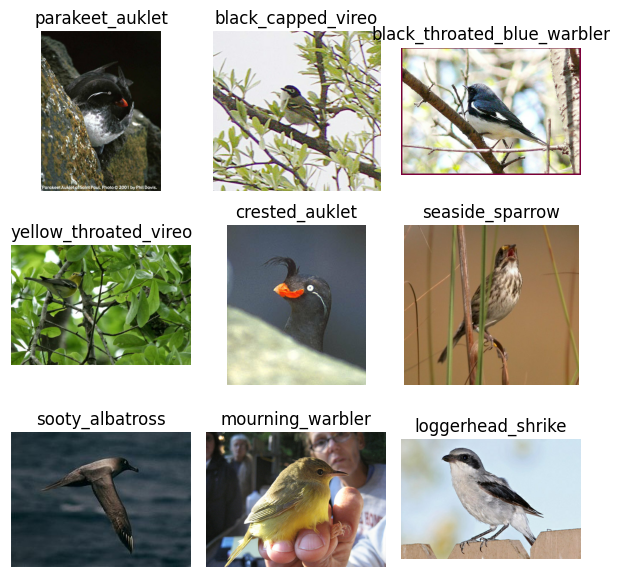

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, example in enumerate(ds_train_full.take(9)):
    image, label = example["image"], example["label_name"]
    ax = axes[i // 3, i % 3]
    ax.imshow(image.numpy())
    ax.set_title(label.numpy().decode("utf-8"))
    ax.axis("off")

plt.tight_layout()
plt.show()

Random image from our training dataset.

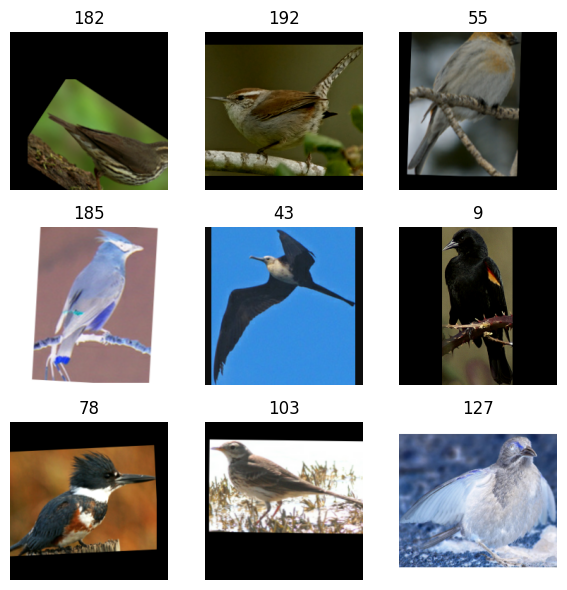

In [9]:
_, axes = plt.subplots(3, 3, figsize=(6, 6))

for batch in ds_train.take(1):
    images, labels = batch
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(images[i].numpy())
        ax.set_title(labels[i].numpy().item())
        ax.axis("off")

plt.tight_layout()
plt.show()

Create a tensorflow CNN model for our dataset.

In [ ]:
def create_conv_block(channels, num_of_convs=3):
    initializer = keras.initializers.HeUniform(seed=SEED)
    convs = []
    for _ in range(0, num_of_convs):
        convs.extend(
            [
                layers.Conv2D(
                    channels,
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding="same",
                    activation="relu",
                    kernel_initializer=initializer,
                ),
                layers.BatchNormalization(axis=1),
            ]
        )

    return keras.Sequential(
        [
            *convs,
            layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            layers.Dropout(0.25),
        ]
    )


def create_vgg_model():
    initializer = keras.initializers.HeUniform(seed=SEED)
    conv_blocks = []
    conv_block_dims = [(64, 2), (128, 2), (256, 3), (512, 3), (512, 3)]
    for channels, num_of_convs in conv_block_dims:
        conv_blocks.append(create_conv_block(channels, num_of_convs))

    linear_head = []
    for _ in range(0, 3):
        linear_head.append(
            keras.Sequential(
                [
                    layers.Dense(
                        4096, activation="relu", kernel_initializer=initializer
                    ),
                    layers.BatchNormalization(axis=1),
                    layers.Dropout(0.8),
                ]
            )
        )

    classifier = keras.Sequential(
        [
            layers.Dense(256, activation="relu", kernel_initializer=initializer),
            layers.Dropout(0.7),
            layers.Dense(256, activation="relu", kernel_initializer=initializer),
            layers.BatchNormalization(axis=1),
            layers.Dropout(0.7),
            layers.Dense(
                NUM_OF_CLASSES,
                activation="softmax",
                dtype="float32",
                kernel_initializer=initializer,
            ),  # 200 classes
        ]
    )

    return keras.Sequential(
        [
            layers.BatchNormalization(axis=1, input_shape=(224, 224, 3)),
            *conv_blocks,
            layers.Flatten(),
            *linear_head,
            classifier,
        ]
    )

Compile the model.

In [ ]:
LEARNING_RATE = 1e-3

model = create_vgg_model()


def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    min_delta=1e-6,
    restore_best_weights=True,
    verbose=True,
)

model.compile(
    optimizer=optimizers.Adam(LEARNING_RATE),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=500,
    steps_per_epoch=250,
    callbacks=[early_stopping, learning_rate_scheduler],
    workers=32,
)

model.summary()
model.save_weights("./checkpoints/custom_checkpoint")

In [ ]:
# Create a new model instance
model = create_vgg_model()

# Restore the weights
model.load_weights("./checkpoints/custom_checkpoint")

Graph the training result.

In [ ]:
history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ["loss", "val_loss"]].plot()
history_frame.loc[
    :, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]
].plot()

Let's view some predictions.

In [ ]:
@tf.function
def preprocess_example_img(src_image, bbox):
    image = utils.normalize_img(src_image, MEAN, STD)
    image = utils.crop_to_bounding_box(image, bbox)
    image = utils.resize_with_pad_img(image, TARGET_HEIGHT, TARGET_WIDTH)
    return image


@tf.function
def preprocess_example(data):
    image = data["image"]
    bbox = data["bbox"]
    model_input = preprocess_example_img(image, bbox)
    return {
        "model_input": model_input,
        "image": image,
        "label": data["label"],
        "label_name": data["label_name"],
        "bbox": bbox,
    }


def predict_example(image):
    assert isinstance(
        image, np.ndarray
    ), f"unexpected image type: {type(image).__name__}"
    image = tf.convert_to_tensor(image)
    assert isinstance(
        image, tf.Tensor
    ), f"unexpected image type: {type(image).__name__}"
    image = tf.expand_dims(image, axis=0)

    pred_probabilities = model.predict(image)

    pred_label = tf.argmax(pred_probabilities[0]).numpy().item()
    return pred_label


ds_test_examples = ds_test_full.map(
    lambda data: preprocess_example(data), num_parallel_calls=tf.data.AUTOTUNE
)

df_example = tfds.as_dataframe(ds_test_examples.take(9))

df_example["image"] = df_example["image"].apply(
    lambda img: Image.fromarray(img, mode="RGB")
)
df_example["pred_label"] = df_example["model_input"].apply(
    lambda image: predict_example(image)
)

df_example = df_example.drop("model_input", axis=1)
df_example = df_example.drop("bbox", axis=1)

df_example.style


def image_to_base64(image: Image) -> str:
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue())
    return img_str.decode("utf-8")


# Function to create an HTML table using DataFrame.
def image_formatter(im):
    return f'<img src="{image_to_base64(im)}" width="50" height="50">'


HTML(df_example.to_html(formatters={"image": image_formatter}, escape=False))

In [ ]:
    assert isinstance(
        image, tf.Tensor
    ), f"unexpected image type: {type(image).__name__}"
    image = tf.expand_dims(image, axis=0)

    pred_probabilities = model.predict(image)

    pred_label = tf.argmax(pred_probabilities[0]).numpy().item()
    return pred_label


ds_test_examples = ds_test_full.map(
    lambda data: preprocess_example(data), num_parallel_calls=tf.data.AUTOTUNE
).shuffle(ds_info.splits["test"].num_examples, SHUFFLE_BUFFER_SIZE)

df_example = tfds.as_dataframe(ds_test_examples.take(9))

df_example["pred_label"] = df_example["model_input"].apply(
    lambda image: predict_example(image)
)

df_example = df_example.drop("model_input", axis=1)
df_example = df_example.drop("bbox", axis=1)

df_example

Try the model with actual pictures!

In [ ]:
def predict_image(img):
    img = img.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 3)
    prediction = model.predict(img).flatten()  # Assume model is your trained model
    prediction_label = np.argmax(prediction)
    return ds_info.features["label"].int2str(
        prediction_label
    )  # Convert the predicted class index back to a label


ds_example = ds_test_full.take(2)
example_images = []
for example in ds_example:
    image = example["image"]
    image = pad_img(image).numpy()
    example_images.append([image])

iface = gr.Interface(
    fn=predict_image,
    inputs=gr.components.Image(type="numpy", shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    outputs="text",
    examples=example_images,
)

iface.launch()